# Challenge Activities

**1** - What steps would you take to solve this problem? Please describe as completely and clearly as possible all the steps that you see as essential for solving the problem.

First of all I would explore de data avaiable to me, it's necessary to know about your dataset. I like to answer de following questions before start actually coding and modeling:

* What does the columns represent?
I have one column categorical that indicates the maintenance category
The other columns indicate quantities os value the impacts directly on the "class" column

* Which columns will I use as labels and features?
I'll use 'class' as label and the rest of the columns as features.

* What kind of problem am I facing?
A binary classification.

* How much data do I have available?
Only 60000 rows for training, DL is not necessary for this amount of data.

After I have to check the missing data and how to deal with then, in this case I decided to fill the 'na' spaces with the column mean. The company passed recently over a digitalization process, and 'na' is in a 'str' type in the dataset. It might indicate that the 'na' spaces were filled manually. Looking at this I cannot assume 0 for the 'na', i don't know if the real value is 0 or it was missed during the process.

Then I check the balance in the dataset, in this case the dataset was completely unbalanced, so I will have to deal with the class weights.

Now, it's time to check and extract statistic information from the dataset, this part helped me with some conclusions about the case. The conclusions are set close to de code. the most important tools were mean,median, standard deviation and correlations with the column 'class'.

At this point I have a clean dataset and I know which columns are most related to the class I want to predict. So it's time to prepare the data for the training and here are the steps:
* Encode the categorical column using Label Encoder
* Divide the datasets in X and y to insert in the traning model.
* Normalize the Train and Test data 
* Get the class weights
* Train the model
* Evaluate the training

In this case I saw the the unbalance present in the dataset affected a lot in the False negatives quantity, so I decided to tune my hyperparameters model using the Recall metric in order to low the False negatives amount.

In the end I have to train e evaluate the model again.

**2** - Which technical data science metric would you use to solve this challenge? Ex: absolute error, rmse, etc.

I would use accuracy, recall, precision and F1-score to evaluate the model

**3** - Which business metric  would you use to solve the challenge?

I would use cost per maintenance metrics combined to the predictive model.



**4** - How do technical metrics relate to the business metrics?

Those metrics will be related after the prediction, the bigger problem is the quantity of trucks that had a defect in any system other than the air system.
If you are able to predict based on the variables which kind of maintenance you will face the costs will be more predictable, and allows the customer to plan batter preventive maintenances.

**5** - What types of analyzes would you like to perform on the customer database?

I would look to the variables distribuition, the means variation, minimum and maximum of each variable. This analisys would be able to show if there are constants on the maintenance process.

**6** - What techniques would you use to reduce the dimensionality of the problem? 

Looking to the row I might use undersampling technique to reduce the 'neg' rows and make the dataset more balanced. But in this case I won't use because the dataset unbalance is verya agressive.
Looking to the columns I would exclude the columns with low correlation with the class 

**7** - What techniques would you use to select variables for your predictive model?

Correlation with the target, in this case, with the class

**8** - What predictive models would you use or test for this problem? Please indicate at least 3.
* Random Forest Classifier
* Light GBM
* XG Boost

**9** - How would you rate which of the trained models is the best?

I have to look the confusion matrix of each model to determine which metric will I use. In this case with the Random Forest Classifier I used the Recall with the confusion matrix to evaluate.

**10** - How would you explain the result of your model? Is it possible to know which variables are most important?

Based on how many True positives and True negatives my model got. It shows the model's reliability.
About the variables, the most important are the variables with more correlation with the classes.   

**11** - How would you assess the financial impact of the proposed model?

With the current data I was able to build a predictive model based on the variables. It will give maintenance predictability to the customer as a consequence the customer would be able to plan preventives maintenances,so that the cost of preventives are $25 and correctives $500 or 2000% difference.  
Adding a time column I would be able to increase the predictability using Time Series techniques 

**12** - What techniques would you use to perform the hyperparameter optimization of the chosen model?

I would use the cross_validation_score on each hyperparameter, scoring on the necessary metric, in this case was the Recall.

**13** - What risks or precautions would you present to the customer before putting this model into production?

I would say that the customer need to be sure to maintain the data as reliable as possible because the model will need to be retrained after some time to keep it updated.
I would also say that the maintenance environment is not necessarily mathematical, emergencies might happen, so is always important to have someone analysing the results with the model.  

**14** - If your predictive model is approved, how would you put it into production?

It depends on what resources I will have. 
It can be hosted in a cloud environment and the model can be acessed through an API. This method can be done using Fast API.
It might be integrated to the customer intern application in the case of the application doens't have any access to the internet. 

**15** - If the model is in production, how would you monitor it?

It's necessary to determinate a threshold in the metrics to determinate when the model need to be updated, it's also important to have records about the predictions. And stablish predictions and error logs.
In this case, I would say that 70% Recall should be the threshold.

**16** - If the model is in production, how would you know when to retrain it?

Stablishing a threshold on the metric, evaluating constatly the predictions, when the metric is under the stablished value, it's time to retrain the model.

# Importing libraries

In [189]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.utils.class_weight import compute_class_weight
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import classification_report 

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import learning_curve
from sklearn.datasets import load_digits


from scipy.stats import spearmanr

# Functions

This section contains all functions I used in this notebook 

In [145]:
def specific_value_counts(df, value, plot=False):
    # Counting specific values 
    value_counts = df.apply(lambda col: (col == value).sum()).reset_index()
    value_counts.columns = ['Column', f'Count {value}']
    
    # Get only columns different of 0
    value_counts = value_counts[value_counts[f'Count {value}'] != 0]
    
    # Show Count
    print(value_counts.to_string(index=False))

    if plot == True:
        plt.figure(figsize=(100, 50))
        plt.bar(value_counts['Column'], value_counts[f'Count {value}'])
        plt.title(f'Count {value}')
        plt.xlabel('Columns')
        plt.ylabel(f'number of {value}')
        plt.xticks(rotation=45)
        plt.show()

In [146]:
def process_na_values(df, value):

    df = df.apply(pd.to_numeric, errors='coerce')

    for col in df.columns:
        col_mean = df[col].replace(value, np.nan).mean()  
        df[col] = df[col].replace(np.nan, col_mean) 
    return df

In [147]:
def plot_violin(df):
    num_columns = df.shape[1]
    num_rows = int(np.ceil(num_columns / 4)) 

    fig, axes = plt.subplots(num_rows, 4, figsize=(20, 5 * num_rows))
    
    # Flatten to easy the interations
    axes = axes.flatten()  
    
    for i, col in enumerate(df.columns):
        sns.violinplot(data=df, x=col, ax=axes[i])
        axes[i].set_title(f'Column Distribuition {col}')
    
    # Remove empty axes
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])
    
    plt.tight_layout()
    plt.show()

In [218]:
def plot_learning_curve(model, title, X, y, cv=None, n_jobs=None):
    plt.figure()
    plt.title(title)
    plt.xlabel("Training examples")
    plt.ylabel("Score")

    # Define train_sizes as an array-like sequence
    
    train_sizes = np.linspace(0.1, 1.0, 5)  # Default to 5 points from 10% to 100% of the data

    train_sizes, train_scores, test_scores = learning_curve(
        model, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes
    )

    train_scores_mean = train_scores.mean(axis=1)
    train_scores_std = train_scores.std(axis=1)
    test_scores_mean = test_scores.mean(axis=1)
    test_scores_std = test_scores.std(axis=1)

    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1, color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")

    plt.legend(loc="best")
    return plt

In [148]:
def evaluate_model(model, X, y):

	cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=42)
	scores = cross_val_score(model, X, y, scoring='recall', 
	                         cv=cv)
	return scores

In [149]:
def get_models_max_depth():

    models = dict()
    depths = [i for i in range(12, 18)] + [None]
    for n in depths:
        models[str(n)] = RandomForestClassifier(random_state=42,
                                                criterion='entropy',
                                                max_depth=n)
    return models

In [150]:
def get_models_n_estimators():

	models = dict()
	n_trees = [10, 50, 80, 100, 150, 200]
	for n in n_trees:
		models[str(n)] = RandomForestClassifier(n_estimators=n,
		                                        max_depth=16,
												criterion='entropy',
												random_state=42)
  
	return models

# Extracting Data

In [151]:
previous_years_df = pd.read_csv('air_system_previous_years.csv')
previous_years_df.head()


,class,aa_000,ab_000,ac_000,ad_000,ae_000,af_000,ag_000,ag_001,ag_002,...,ee_002,ee_003,ee_004,ee_005,ee_006,ee_007,ee_008,ee_009,ef_000,eg_000
0,neg,76698,na,2130706438,280,0,0,0,0,0,...,1240520,493384,721044,469792,339156,157956,73224,0,0,0
1,neg,33058,na,0,na,0,0,0,0,0,...,421400,178064,293306,245416,133654,81140,97576,1500,0,0
2,neg,41040,na,228,100,0,0,0,0,0,...,277378,159812,423992,409564,320746,158022,95128,514,0,0
3,neg,12,0,70,66,0,10,0,0,0,...,240,46,58,44,10,0,0,0,4,32
4,neg,60874,na,1368,458,0,0,0,0,0,...,622012,229790,405298,347188,286954,311560,433954,1218,0,0


In [152]:
present_year_df = pd.read_csv('air_system_present_year.csv')
present_year_df.head()

,class,aa_000,ab_000,ac_000,ad_000,ae_000,af_000,ag_000,ag_001,ag_002,...,ee_002,ee_003,ee_004,ee_005,ee_006,ee_007,ee_008,ee_009,ef_000,eg_000
0,neg,60,0,20,12,0,0,0,0,0,...,1098,138,412,654,78,88,0,0,0,0
1,neg,82,0,68,40,0,0,0,0,0,...,1068,276,1620,116,86,462,0,0,0,0
2,neg,66002,2,212,112,0,0,0,0,0,...,495076,380368,440134,269556,1315022,153680,516,0,0,0
3,neg,59816,na,1010,936,0,0,0,0,0,...,540820,243270,483302,485332,431376,210074,281662,3232,0,0
4,neg,1814,na,156,140,0,0,0,0,0,...,7646,4144,18466,49782,3176,482,76,0,0,0


# Processing Data

## Exploring Data

In [153]:
specific_value_counts(previous_years_df,'neg')
specific_value_counts(previous_years_df,'pos')


Column  Count neg
 class      59000
Column  Count pos
 class       1000


Here we can see that this trai dataset is unbalanced, It might interfer on my posterior model, but I'll try fix this using it's wight balance

Column  Count na
ab_000     46329
ac_000      3335
ad_000     14861
ae_000      2500
af_000      2500
ag_000       671
ag_001       671
ag_002       671
ag_003       671
ag_004       671
ag_005       671
ag_006       671
ag_007       671
ag_008       671
ag_009       671
ah_000       645
ai_000       629
aj_000       629
ak_000      4400
al_000       642
  am_0       629
an_000       642
ao_000       589
ap_000       642
aq_000       589
ar_000      2723
as_000       629
at_000       629
au_000       629
av_000      2500
ax_000      2501
ay_000       671
ay_001       671
ay_002       671
ay_003       671
ay_004       671
ay_005       671
ay_006       671
ay_007       671
ay_008       671
ay_009       671
az_000       671
az_001       671
az_002       671
az_003       671
az_004       671
az_005       671
az_006       671
az_007       671
az_008       671
az_009       671
ba_000       688
ba_001       688
ba_002       688
ba_003       688
ba_004       688
ba_005       688
ba_006       6

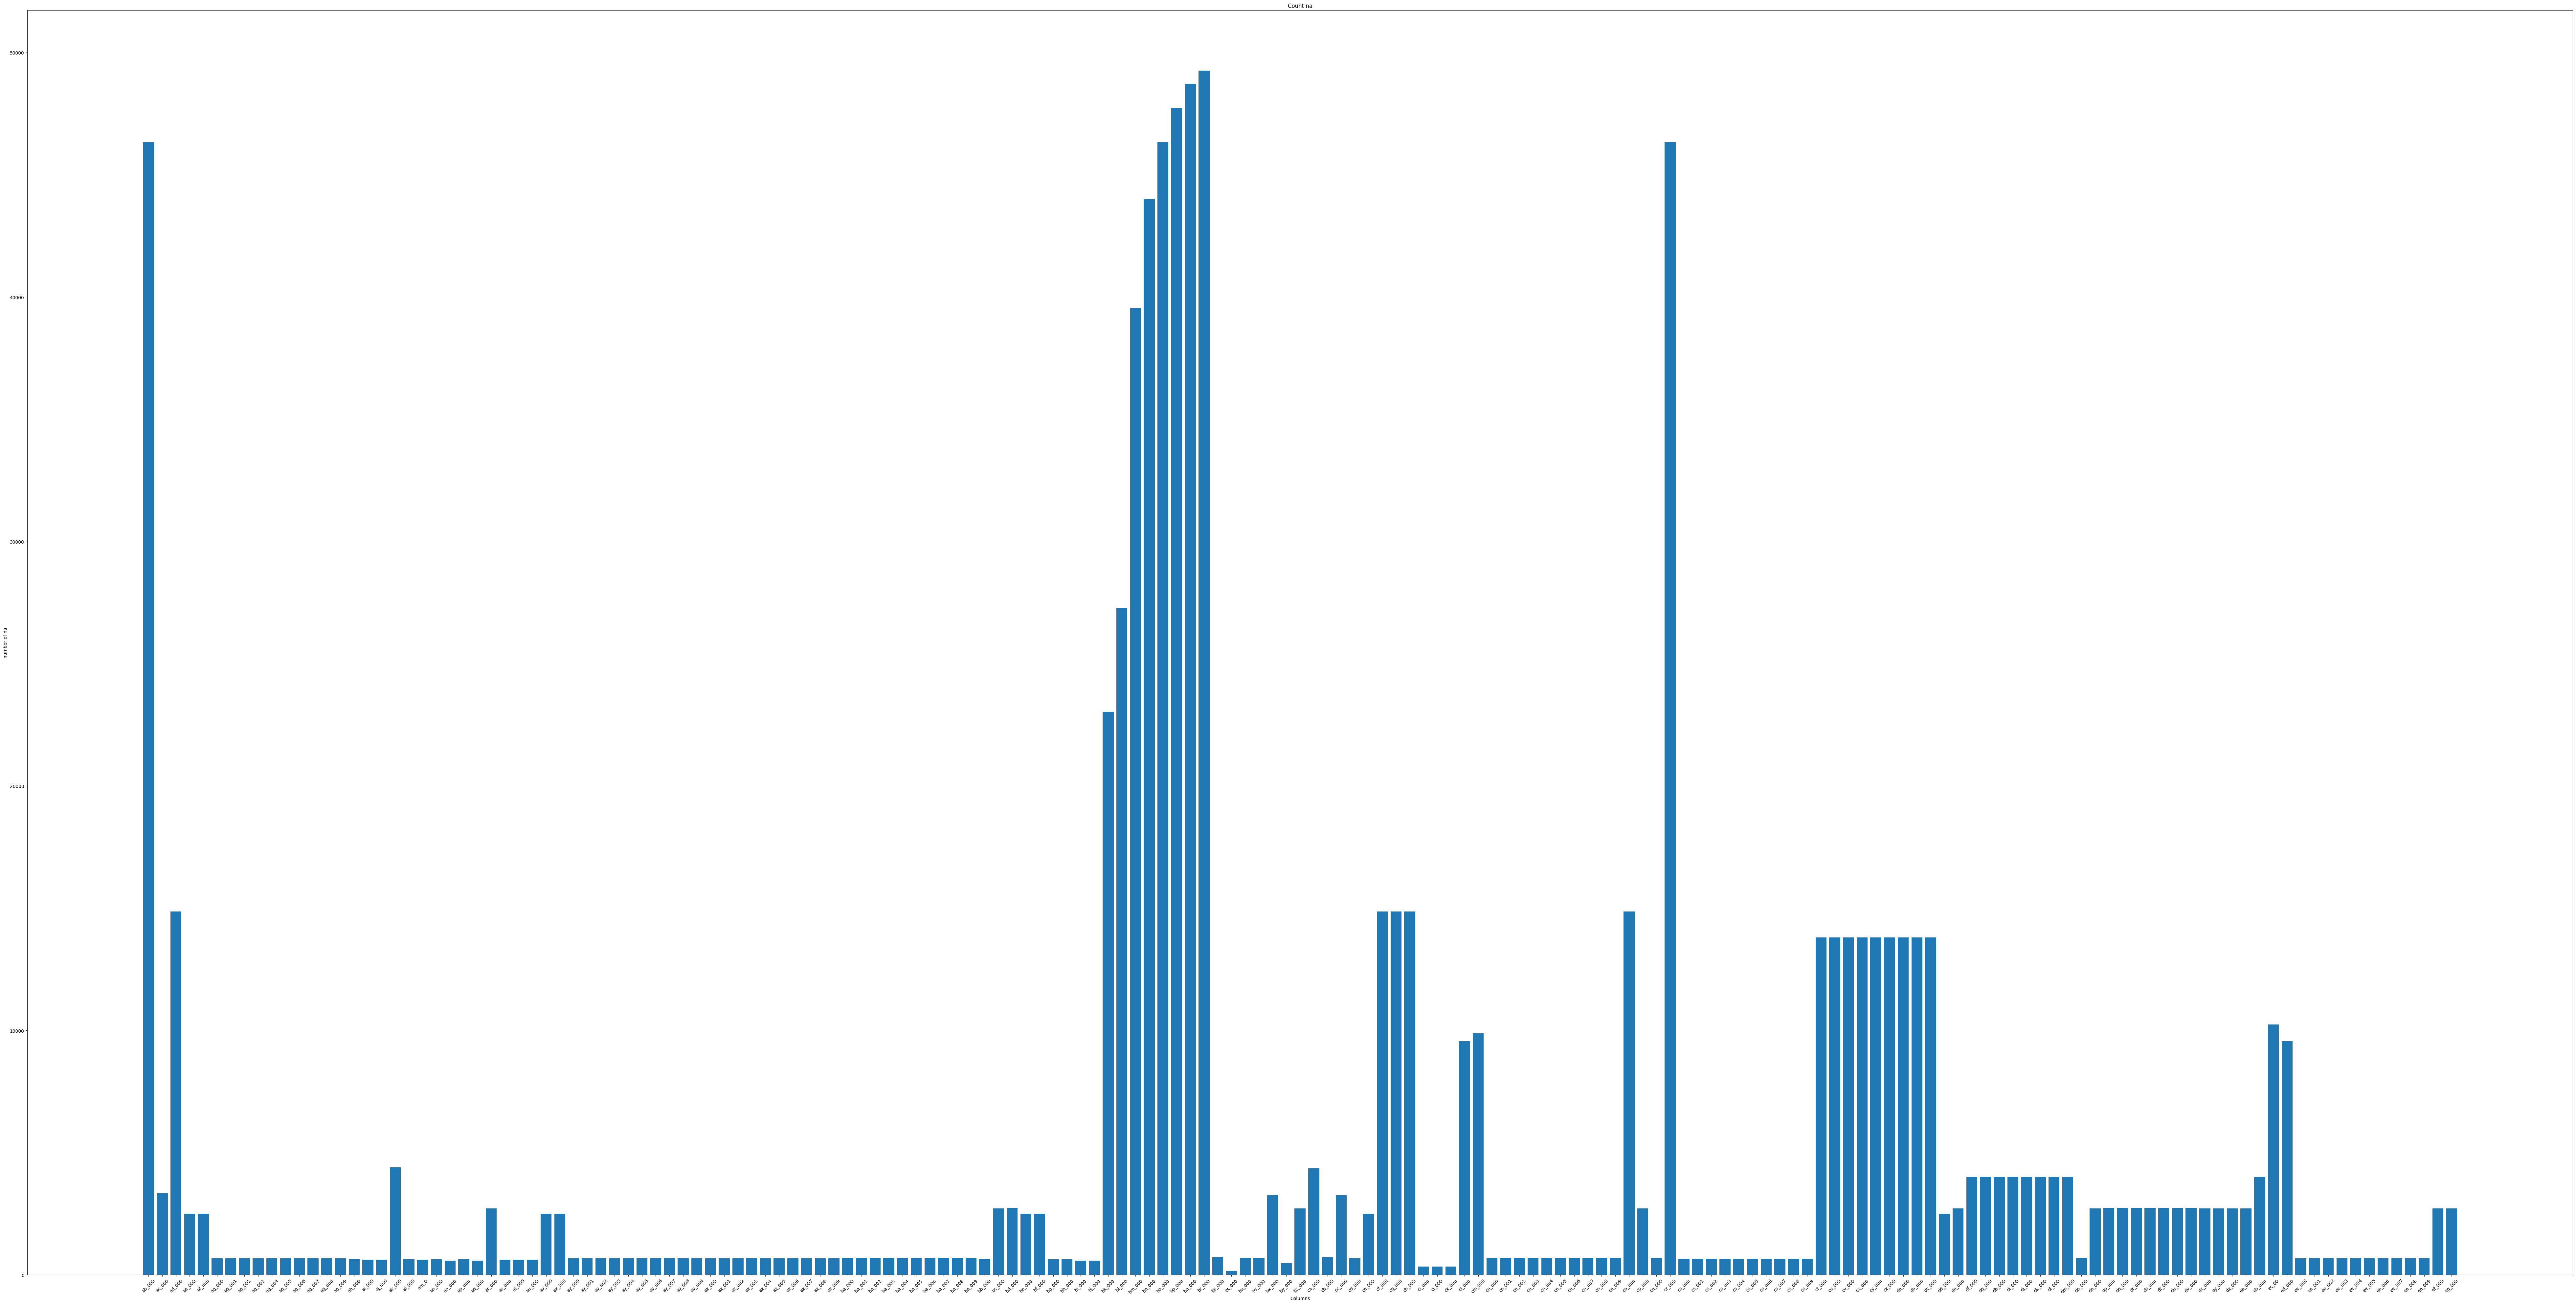

In [154]:
df_na = specific_value_counts(previous_years_df,'na',plot=True)

The dataset is also full os 'na' values, the values were inserted in str form so it's another point i have to be aware of.
For this problem I'll fill the 'na' values with the column mean. I can't be sure if the 'na' value is only 0 or the loss of this information during the digitalization process.

### Questions

This section is dedicated to solve the plataform test, it will also help me to extract some statistics information about the dataset

In [155]:
print(f"Just {1000/59000*100}% of the maintenances are in the air system")


Just 1.694915254237288% of the maintenances are in the air system


In [156]:
# mean, median, standard deviation with the null values 
# directly will give me an error 
# convertin the column to numeric i'm able to caculate using the functions below
metrics = previous_years_df.copy()
metrics = pd.to_numeric(metrics["ee_003"],errors='coerce')

mean =metrics.mean()
median =metrics.median()
std_deviation = metrics.std()

print(mean)
print(median)
print(std_deviation)

211126.44730233107
112086.0
543318.8167085947


In [157]:
exercise_4 = previous_years_df.copy()
exercise_4 = exercise_4['ag_002']

exercise_4 = exercise_4[exercise_4!= 'na']

exercise_4 = pd.to_numeric(exercise_4)

print(exercise_4.mean())
print(exercise_4.median())
print(exercise_4.std())

8606.014529151005
0.0
150322.02853886687


In [158]:
exercise_5 =previous_years_df.copy()
exercise_5 = exercise_5[['ee_007','ag_002']]

exercise_5 = exercise_5[~(exercise_5 == 'na').any(axis=1)]

exercise_5['ee_007'] = pd.to_numeric(exercise_5['ee_007'])
exercise_5['ag_002'] = pd.to_numeric(exercise_5['ag_002'])

corr, pvalue = spearmanr(exercise_5['ag_002'], exercise_5['ee_007'])
print(corr)

0.19508353891062494


In [159]:
exercise_6 =previous_years_df.copy()
exercise_6 = exercise_6[['ee_005','ac_000']]

exercise_6 = exercise_6[~(exercise_6 == 'na').any(axis=1)]

exercise_6['ee_005'] = pd.to_numeric(exercise_6['ee_005'])
exercise_6['ac_000'] = pd.to_numeric(exercise_6['ac_000'])

corr, pvalue = spearmanr(exercise_6['ee_005'], exercise_6['ac_000'])
print(corr)

0.3190163789974874


In [160]:
exercise_7 = previous_years_df.copy()
exercise_7 = exercise_7[['class','ad_000']]

#exercise_7 = exercise_7.astype(str)

exercise_7 = exercise_7[~(exercise_7 == 'na').any(axis=1)]

exercise_7['ad_000'] = pd.to_numeric(exercise_7['ad_000'])

exercise_7= exercise_7.groupby('class')

exercise_7['ad_000'].median()

class
neg    124.0
pos    648.0
Name: ad_000, dtype: float64

In [161]:
exercise_8 = previous_years_df.copy()
exercise_8 = exercise_8[['class','ee_001']]

#exercise_8 = exercise_8.astype(str)

exercise_8 = exercise_8[~(exercise_8 == 'na').any(axis=1)]

exercise_8['ee_001'] = pd.to_numeric(exercise_8['ee_001'])

exercise_8= exercise_8.groupby('class')

exercise_8['ee_001'].mean()

class
neg    6.615160e+05
pos    7.957408e+06
Name: ee_001, dtype: float64

In [162]:
exercise_9 = previous_years_df.copy()

total_null_counts = (exercise_9=='na').sum().sum()

print(total_null_counts)

850015


In [163]:
exercise_10 = previous_years_df.copy()

column_null_counts = (exercise_10=='na').sum()
sorted_columns = column_null_counts.sort_values(ascending=False)

print(sorted_columns)

br_000    49264
bq_000    48722
bp_000    47740
bo_000    46333
ab_000    46329
          ...  
cj_000      338
ci_000      338
bt_000      167
aa_000        0
class         0
Length: 171, dtype: int64


In [164]:
exercise_12 = previous_years_df.copy()
exercise_12 = exercise_12['ci_000']

exercise_12 = exercise_12[exercise_12 != 'na']

exercise_12 = pd.to_numeric(exercise_12)

total = exercise_12.quantile(0.32)

print(total)

96517.5552


## Cleaning the dataset

The same process must be done in both datasets (previous years, present year), as is asked in the challenge documentation, the present year dataset will be used as the test dataset.

In [165]:
# make a copy just for processing and drop the class column, it will be inserted again 
df_work_previous_years = previous_years_df.copy()
df_work_previous_years = df_work_previous_years.drop('class', axis=1)

df_work_present_year = present_year_df.copy()
df_work_present_year = df_work_present_year.drop('class', axis=1)

#Treating "na" values
df_treated_previous = process_na_values(df_work_previous_years, 'na')
df_treated_present = process_na_values(df_work_present_year, 'na')

#inserting again the class columns
df_treated_previous['class'] = previous_years_df['class']
df_treated_present['class'] = present_year_df['class']

df_treated_previous.head()

C:\Users\T-GAMER\AppData\Local\Temp\ipykernel_39012\1510349651.py:13: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_treated_previous['class'] = previous_years_df['class']
C:\Users\T-GAMER\AppData\Local\Temp\ipykernel_39012\1510349651.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_treated_present['class'] = present_year_df['class']


,aa_000,ab_000,ac_000,ad_000,ae_000,af_000,ag_000,ag_001,ag_002,ag_003,...,ee_003,ee_004,ee_005,ee_006,ee_007,ee_008,ee_009,ef_000,eg_000,class
0,76698,0.713189,2.130706e+09,280.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,493384.0,721044.0,469792.0,339156.0,157956.0,73224.0,0.0,0.0,0.0,neg
1,33058,0.713189,0.000000e+00,190620.639314,0.0,0.0,0.0,0.0,0.0,0.0,...,178064.0,293306.0,245416.0,133654.0,81140.0,97576.0,1500.0,0.0,0.0,neg
2,41040,0.713189,2.280000e+02,100.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,159812.0,423992.0,409564.0,320746.0,158022.0,95128.0,514.0,0.0,0.0,neg
3,12,0.000000,7.000000e+01,66.000000,0.0,10.0,0.0,0.0,0.0,318.0,...,46.0,58.0,44.0,10.0,0.0,0.0,0.0,4.0,32.0,neg
4,60874,0.713189,1.368000e+03,458.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,229790.0,405298.0,347188.0,286954.0,311560.0,433954.0,1218.0,0.0,0.0,neg


In [166]:
df_treated_present.head()

,aa_000,ab_000,ac_000,ad_000,ae_000,af_000,ag_000,ag_001,ag_002,ag_003,...,ee_003,ee_004,ee_005,ee_006,ee_007,ee_008,ee_009,ef_000,eg_000,class
0,60,0.000000,20.0,12.0,0.0,0.0,0.0,0.0,0.0,2682.0,...,138.0,412.0,654.0,78.0,88.0,0.0,0.0,0.0,0.0,neg
1,82,0.000000,68.0,40.0,0.0,0.0,0.0,0.0,0.0,0.0,...,276.0,1620.0,116.0,86.0,462.0,0.0,0.0,0.0,0.0,neg
2,66002,2.000000,212.0,112.0,0.0,0.0,0.0,0.0,0.0,199486.0,...,380368.0,440134.0,269556.0,1315022.0,153680.0,516.0,0.0,0.0,0.0,neg
3,59816,0.772065,1010.0,936.0,0.0,0.0,0.0,0.0,0.0,0.0,...,243270.0,483302.0,485332.0,431376.0,210074.0,281662.0,3232.0,0.0,0.0,neg
4,1814,0.772065,156.0,140.0,0.0,0.0,0.0,0.0,0.0,0.0,...,4144.0,18466.0,49782.0,3176.0,482.0,76.0,0.0,0.0,0.0,neg


Here we have clean datasets ready to be used. I'll have a closer look into these columns before building the model. 

## Statistics

In [167]:
df_treated_present.describe()

,aa_000,ab_000,ac_000,ad_000,ae_000,af_000,ag_000,ag_001,ag_002,ag_003,...,ee_002,ee_003,ee_004,ee_005,ee_006,ee_007,ee_008,ee_009,ef_000,eg_000
count,1.600000e+04,16000.000000,1.600000e+04,16000.000000,16000.000000,16000.000000,16000.000000,1.600000e+04,1.600000e+04,1.600000e+04,...,1.600000e+04,1.600000e+04,1.600000e+04,1.600000e+04,1.600000e+04,1.600000e+04,1.600000e+04,1.600000e+04,16000.000000,16000.000000
mean,6.799698e+04,0.772065,3.580393e+08,439.498794,6.428347,10.195950,120.858516,2.064204e+03,1.379236e+04,1.126276e+05,...,4.649135e+05,2.212010e+05,4.690886e+05,4.256696e+05,3.559239e+05,3.524014e+05,1.442759e+05,8.560355e+03,0.064969,0.242683
std,5.035350e+05,1.234341,7.732974e+08,1344.538809,115.609827,163.613934,6416.421814,8.872900e+04,2.344434e+05,1.019765e+06,...,1.247643e+06,5.793611e+05,1.259921e+06,1.251979e+06,1.192324e+06,1.618743e+06,5.335916e+05,5.297868e+04,3.293313,13.993423
min,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000
25%,9.280000e+02,0.772065,2.000000e+01,42.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,...,3.293500e+03,1.300000e+03,3.103000e+03,4.185500e+03,6.720000e+02,1.380000e+02,0.000000e+00,0.000000e+00,0.000000,0.000000
50%,3.098200e+04,0.772065,2.000000e+02,296.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,...,2.464390e+05,1.177300e+05,2.350240e+05,2.025010e+05,1.049940e+05,4.466800e+04,4.540000e+03,0.000000e+00,0.000000,0.000000
75%,4.947900e+04,0.772065,1.859000e+03,439.498794,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,...,4.509875e+05,2.212010e+05,4.690886e+05,4.138220e+05,2.875085e+05,1.762320e+05,1.442759e+05,2.226500e+03,0.000000,0.000000
max,4.294967e+07,58.000000,2.130707e+09,87038.000000,11044.000000,14186.000000,736174.000000,1.047252e+07,1.914916e+07,7.305747e+07,...,5.382333e+07,2.207969e+07,4.859750e+07,5.604348e+07,4.215944e+07,4.747137e+07,1.718575e+07,4.570398e+06,340.000000,1720.000000


In [168]:
df_treated_previous.describe()

,aa_000,ab_000,ac_000,ad_000,ae_000,af_000,ag_000,ag_001,ag_002,ag_003,...,ee_002,ee_003,ee_004,ee_005,ee_006,ee_007,ee_008,ee_009,ef_000,eg_000
count,6.000000e+04,60000.000000,6.000000e+04,6.000000e+04,60000.000000,60000.000000,6.000000e+04,6.000000e+04,6.000000e+04,6.000000e+04,...,6.000000e+04,6.000000e+04,6.000000e+04,6.000000e+04,6.000000e+04,6.000000e+04,6.000000e+04,6.000000e+04,60000.000000,60000.000000
mean,5.933650e+04,0.713189,3.560143e+08,1.906206e+05,6.819130,11.006817,2.216364e+02,9.757223e+02,8.606015e+03,8.859128e+04,...,4.454897e+05,2.111264e+05,4.457343e+05,3.939462e+05,3.330582e+05,3.462714e+05,1.387300e+05,8.388915e+03,0.090579,0.212756
std,1.454301e+05,1.660588,7.724678e+08,3.504515e+07,158.142022,205.375337,2.036363e+04,3.400875e+04,1.494791e+05,7.574598e+05,...,1.149060e+06,5.402722e+05,1.161763e+06,1.114758e+06,1.063164e+06,1.718366e+06,4.469894e+05,4.720424e+04,4.268529,8.627929
min,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000
25%,8.340000e+02,0.713189,2.000000e+01,4.200000e+01,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,3.033500e+03,1.204000e+03,2.848500e+03,3.839000e+03,5.600000e+02,1.180000e+02,0.000000e+00,0.000000e+00,0.000000,0.000000
50%,3.077600e+04,0.713189,1.880000e+02,2.880000e+02,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,2.397270e+05,1.148530e+05,2.283220e+05,1.960600e+05,9.976600e+04,4.358700e+04,4.474000e+03,0.000000e+00,0.000000,0.000000
75%,4.866800e+04,0.713189,1.686000e+03,8.426500e+03,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,4.454897e+05,2.164440e+05,4.624655e+05,4.003010e+05,2.833455e+05,1.732245e+05,1.387300e+05,2.366000e+03,0.000000,0.000000
max,2.746564e+06,204.000000,2.130707e+09,8.584298e+09,21050.000000,20070.000000,3.376892e+06,4.109372e+06,1.055286e+07,6.340207e+07,...,7.793393e+07,3.775839e+07,9.715238e+07,5.743524e+07,3.160781e+07,1.195801e+08,1.926740e+07,3.810078e+06,482.000000,1146.000000


Analysing the reports above I can conclude:

* The Dataset had an appropriate treatment, all the information remains in the dataset
* Any of the variables is always broken, all columns have 0 as a minimun
* The mean has a high variability among the columns, it indicates a price variation or the recurrence of defects in this variable.
* The maximum field reinforces the affirmation above

### Graphs

Let's have a graphical view

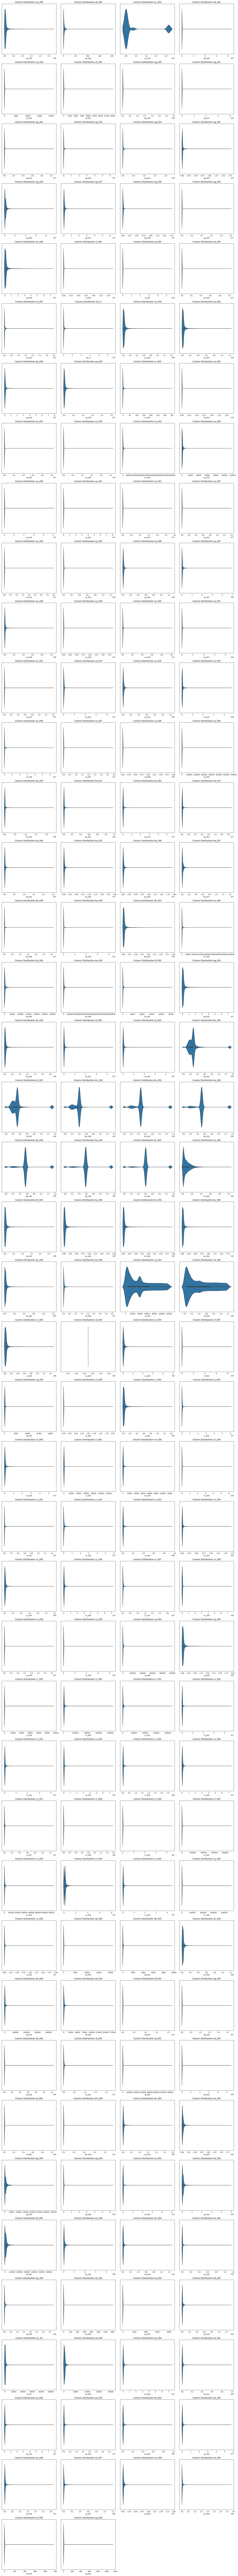

In [169]:
columns = df_treated_previous.drop('class', axis=1)
plot_violin(columns)

We can see that just a few columns are really distributed, It happens because of the column range or because of the value when a defect happens on this variable is more constant and as a consequense more predictable.

Now I'll see how correlated the columns are with the class.

### Encoder

The class column is categorical and must be encoder for modeling.
this process also helps with correlation calculations because turns the data into numeric.

In [170]:
class_previous = df_treated_previous['class']
class_present = df_treated_present['class']

In [171]:
le = LabelEncoder()
class_previous = le.fit_transform(class_previous)
class_present = le.transform(class_present)
encoder = le

In [172]:
train_df = df_treated_previous.drop('class', axis=1)
test_df = df_treated_present.drop('class', axis=1)

train_df['class'] = class_previous
test_df['class'] = class_present

print(f'Encoded values (train): { train_df["class"].unique() }')
print(f'Encoded values (test): { test_df["class"].unique() }')
train_df.head()

Encoded values (train): [0 1]
Encoded values (test): [0 1]


C:\Users\T-GAMER\AppData\Local\Temp\ipykernel_39012\2710428818.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  train_df['class'] = class_previous
C:\Users\T-GAMER\AppData\Local\Temp\ipykernel_39012\2710428818.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  test_df['class'] = class_present


,aa_000,ab_000,ac_000,ad_000,ae_000,af_000,ag_000,ag_001,ag_002,ag_003,...,ee_003,ee_004,ee_005,ee_006,ee_007,ee_008,ee_009,ef_000,eg_000,class
0,76698,0.713189,2.130706e+09,280.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,493384.0,721044.0,469792.0,339156.0,157956.0,73224.0,0.0,0.0,0.0,0
1,33058,0.713189,0.000000e+00,190620.639314,0.0,0.0,0.0,0.0,0.0,0.0,...,178064.0,293306.0,245416.0,133654.0,81140.0,97576.0,1500.0,0.0,0.0,0
2,41040,0.713189,2.280000e+02,100.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,159812.0,423992.0,409564.0,320746.0,158022.0,95128.0,514.0,0.0,0.0,0
3,12,0.000000,7.000000e+01,66.000000,0.0,10.0,0.0,0.0,0.0,318.0,...,46.0,58.0,44.0,10.0,0.0,0.0,0.0,4.0,32.0,0
4,60874,0.713189,1.368000e+03,458.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,229790.0,405298.0,347188.0,286954.0,311560.0,433954.0,1218.0,0.0,0.0,0


In [173]:
test_df.head()

,aa_000,ab_000,ac_000,ad_000,ae_000,af_000,ag_000,ag_001,ag_002,ag_003,...,ee_003,ee_004,ee_005,ee_006,ee_007,ee_008,ee_009,ef_000,eg_000,class
0,60,0.000000,20.0,12.0,0.0,0.0,0.0,0.0,0.0,2682.0,...,138.0,412.0,654.0,78.0,88.0,0.0,0.0,0.0,0.0,0
1,82,0.000000,68.0,40.0,0.0,0.0,0.0,0.0,0.0,0.0,...,276.0,1620.0,116.0,86.0,462.0,0.0,0.0,0.0,0.0,0
2,66002,2.000000,212.0,112.0,0.0,0.0,0.0,0.0,0.0,199486.0,...,380368.0,440134.0,269556.0,1315022.0,153680.0,516.0,0.0,0.0,0.0,0
3,59816,0.772065,1010.0,936.0,0.0,0.0,0.0,0.0,0.0,0.0,...,243270.0,483302.0,485332.0,431376.0,210074.0,281662.0,3232.0,0.0,0.0,0
4,1814,0.772065,156.0,140.0,0.0,0.0,0.0,0.0,0.0,0.0,...,4144.0,18466.0,49782.0,3176.0,482.0,76.0,0.0,0.0,0.0,0


### Correlations

c:\Users\T-GAMER\OneDrive\Área de Trabalho\Challenge\.venv\Lib\site-packages\numpy\lib\_function_base_impl.py:2922: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Users\T-GAMER\OneDrive\Área de Trabalho\Challenge\.venv\Lib\site-packages\numpy\lib\_function_base_impl.py:2923: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


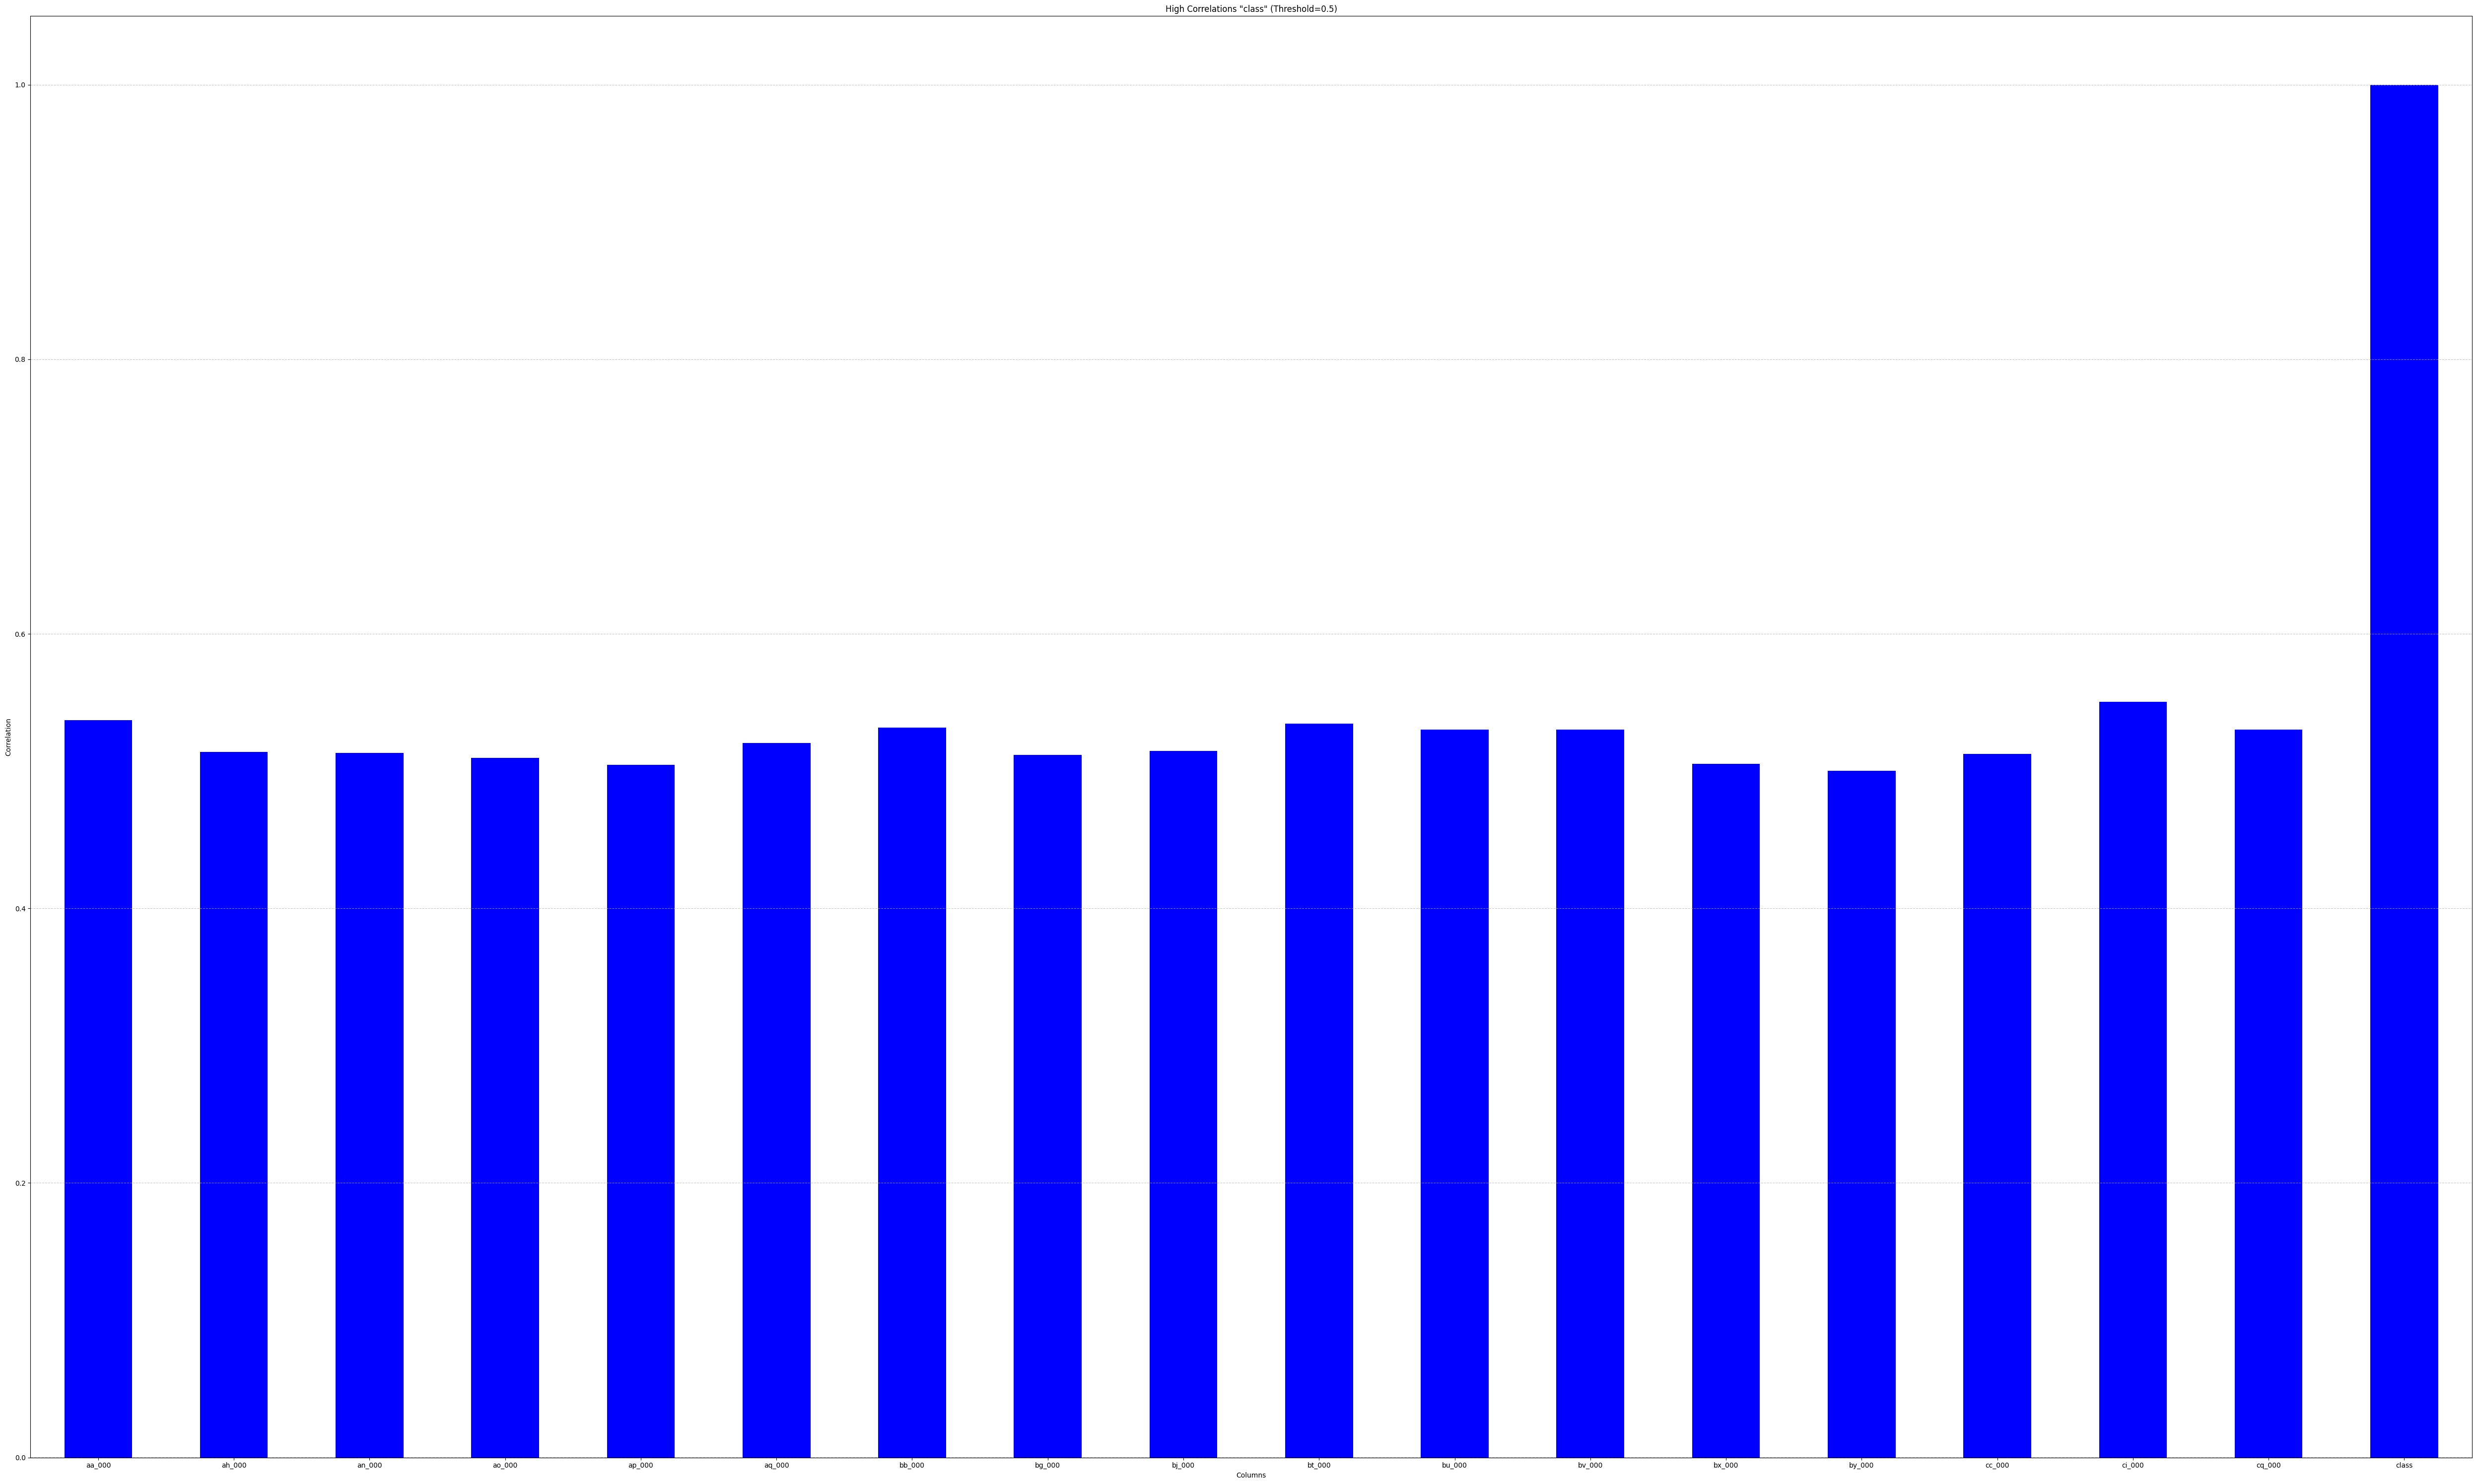

In [174]:
target_column = 'class'

# Correlation matrix using the column class as target
correlations = train_df.corrwith(train_df[target_column])

threshold = 0.5

# Filter of high correlations
high_correlations_pos = correlations[abs(correlations) >= threshold]
list_train = high_correlations_pos.index.tolist()

# Plotar as maiores correlações
plt.figure(figsize=(50, 30))
high_correlations_pos.plot(kind='bar', color='blue')
plt.axhline(y=0, color='black', linestyle='--', linewidth=1) 
plt.title(f'High Correlations "{target_column}" (Threshold={threshold})')
plt.xlabel('Columns')
plt.ylabel('Correlation')
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [175]:
list_sorted = sorted(list_train, reverse=True)
list_sorted.pop(1)

print(f"Number of high correlation factors in total maintenance cost is: {len(list_train)-1} factors")
print(list_sorted)

Number of high correlation factors in total maintenance cost is: 17 factors
['cq_000', 'ci_000', 'cc_000', 'by_000', 'bx_000', 'bv_000', 'bu_000', 'bt_000', 'bj_000', 'bg_000', 'bb_000', 'aq_000', 'ap_000', 'ao_000', 'an_000', 'ah_000', 'aa_000']


Here we are able to see that the dataset has 17 factors high correlated to the class

In [176]:
target_column = 'class'

# Correlation matrix using the column class as target
correlations = train_df.corrwith(train_df[target_column])

threshold = 0.05

# Filter of low correlations
low_correlations_pos = correlations[abs(correlations) <= threshold]
low_list_train = low_correlations_pos.index.tolist()

print(f"Number of high correlation factors in total maintenance cost is: {len(low_list_train)-1} factors")
print(low_list_train)


Number of high correlation factors in total maintenance cost is: 33 factors
['ab_000', 'ac_000', 'ad_000', 'ae_000', 'af_000', 'ag_000', 'aj_000', 'ak_000', 'as_000', 'ay_009', 'az_008', 'az_009', 'bl_000', 'bm_000', 'ca_000', 'cf_000', 'ch_000', 'co_000', 'cr_000', 'cs_008', 'cs_009', 'ct_000', 'cz_000', 'da_000', 'db_000', 'dh_000', 'dj_000', 'dk_000', 'dl_000', 'dm_000', 'dz_000', 'ea_000', 'ef_000', 'eg_000']


c:\Users\T-GAMER\OneDrive\Área de Trabalho\Challenge\.venv\Lib\site-packages\numpy\lib\_function_base_impl.py:2922: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Users\T-GAMER\OneDrive\Área de Trabalho\Challenge\.venv\Lib\site-packages\numpy\lib\_function_base_impl.py:2923: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


This list includes all low correlated columns, which will be dropped out the X datasets to decrease the dimensions 

# Modeling

For this problem I'll a use binary classification model to predict the class based on the variables

## Preparing Data

In [207]:
X_train = train_df.drop('class', axis=1)
X_test = test_df.drop('class', axis=1)


#X_train = train_df.drop(low_list_train, axis=1)
#X_test = test_df.drop(low_list_train, axis=1)

y_train = train_df['class']
y_test = test_df['class']

print("Dimension X_Train:",X_train.shape)
print("Dimension X_Test:",X_test.shape)
print("Dimension y_Train:",y_train.shape)
print("Dimension y_Test:",y_test.shape)

Dimension X_Train: (60000, 170)
Dimension X_Test: (16000, 170)
Dimension y_Train: (60000,)
Dimension y_Test: (16000,)


This command lines commented increase a lot the overfitting, that's why I decided to take those off this case, but the ideal training requires a more balanced dataset.  

## Normalizing

In [209]:
norm = StandardScaler()

X_train = norm.fit_transform(X_train)
X_test = norm.transform(X_test)

## Getting class weights

In [210]:
weights = compute_class_weight('balanced', 
                               classes=np.unique(y_train), 
                               y=y_train)
class_weights = {0: weights[0], 1: weights[1]}
class_weights

{0: np.float64(0.5084745762711864), 1: np.float64(30.0)}

The Dataset is extremely unbalanced, I will use those to train the ML model

# Training the model

I'll use the Random Forest classifier 

In [211]:
rf = RandomForestClassifier(random_state=42,
                                 criterion='entropy',
                                 class_weight = class_weights )
rf.fit(X_train, y_train)

RandomForestClassifier(class_weight={0: np.float64(0.5084745762711864),
                                     1: np.float64(30.0)},
                       criterion='entropy', random_state=42)

## Evaluation

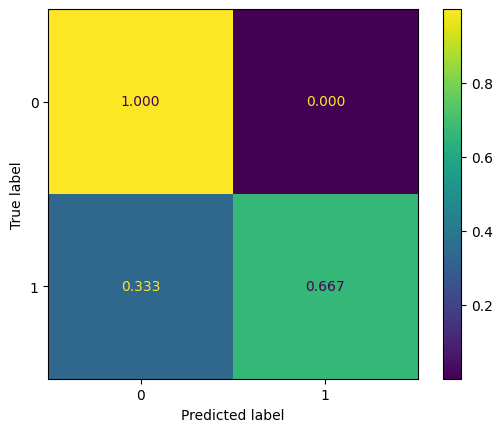

In [212]:
ConfusionMatrixDisplay.from_estimator(rf, X_test, y_test, 
                                      normalize='true', 
                                      values_format='.3f')
plt.show()

The 'pos' has a large unbalance it impacted directly on it's accuracy let's try tune the hyperparameters.

In this scenario I will evaluate the hyperparameters using the Recall as metrics, because I had a few False negatives 

## Hyperparameters

**This part is not necessary to execute, that's how I found the best hyperparameters.**

### Max_depth

>12 0.992 (0.011)
>13 0.991 (0.013)
>14 0.991 (0.013)
>15 0.989 (0.015)
>16 0.989 (0.014)
>17 0.990 (0.015)
>None 0.992 (0.011)



C:\Users\T-GAMER\AppData\Local\Temp\ipykernel_39012\4007750413.py:13: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(results, labels=names, showmeans=True)


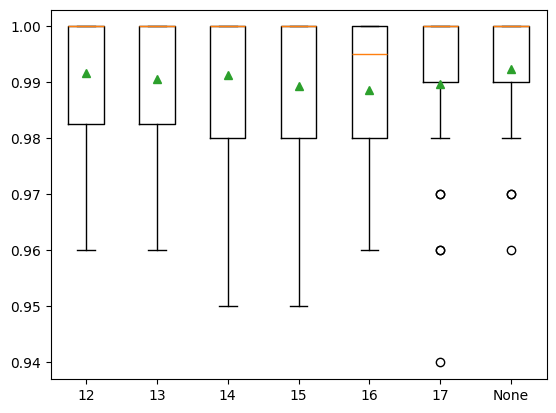

In [182]:
models = get_models_max_depth()
results, names = list(), list()

for name, model in models.items():

    scores = evaluate_model(model, X_train, y_train)
    results.append(scores)
    names.append(name)

    print(f'>{name} {np.mean(scores):.3f} ({np.std(scores):.3f})')

print()
plt.boxplot(results, labels=names, showmeans=True)
plt.show()

Here I'll get 16 as max_depth

### N_estimators

In [183]:
models = get_models_n_estimators()

# Varia o modelo e guarda desempenho
results, names = list(), list()
for name, model in models.items():

	scores = evaluate_model(model, X_train, y_train)

	results.append(scores)
	names.append(name)
 
	# Resultados numéricos
	print(f'>{name} {np.mean(scores):.3f} ({np.std(scores):.3f})')
 
# Boxplot comprativo de cada modelo
plt.boxplot(results, labels=names, showmeans=True)
plt.show()

>10 0.928 (0.039)
>50 0.979 (0.017)


KeyboardInterrupt: 

## New Training

Here I'll retrain the model using the new hyperparameters 

In [214]:
rf_tune = RandomForestClassifier(random_state=42,
                            n_estimators=150,
                            criterion='entropy',
                            max_depth=16,
                            class_weight=class_weights)
rf_tune.fit(X_train, y_train)

RandomForestClassifier(class_weight={0: np.float64(0.5084745762711864),
                                     1: np.float64(30.0)},
                       criterion='entropy', max_depth=16, n_estimators=150,
                       random_state=42)

## Final Evaluation

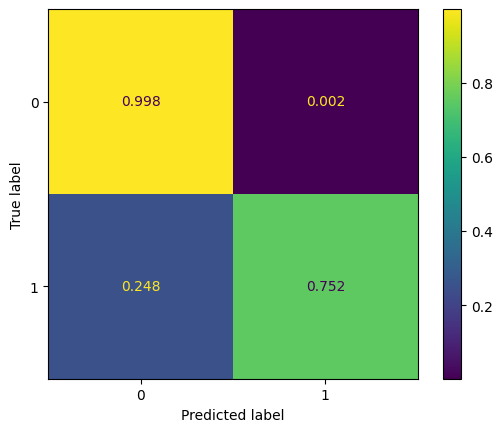

In [215]:
ConfusionMatrixDisplay.from_estimator(rf_tune, X_test, y_test, 
                                      normalize='true', 
                                      values_format='.3f')
plt.show()

In [216]:
y_pred = rf_tune.predict(X_test) 
print(classification_report(y_true = y_test,y_pred = y_pred,digits = 4))

              precision    recall  f1-score   support

           0     0.9941    0.9976    0.9958     15625
           1     0.8840    0.7520    0.8127       375

    accuracy                         0.9919     16000
   macro avg     0.9390    0.8748    0.9043     16000
weighted avg     0.9915    0.9919    0.9916     16000



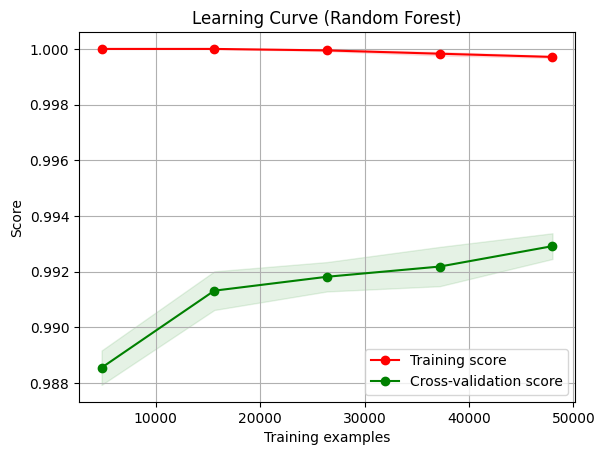

In [217]:
plot_learning_curve(rf_tune, "Learning Curve (Random Forest)", X_train, y_train, cv=5, n_jobs=4)
plt.show()

# Conclusion

The model is getting overfitting but still have a at least 75% of certain in it's predictions
It can be fixed with a more balanced data, so the model won't tend to any class.

Anyway, this model can deacrease drastically the maintenance costs if combined with preventive maintenance planning